In [40]:
from __future__ import division
import xgboost as xgb
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


0it [00:00, ?it/s]



In [48]:
df_train = pd.read_csv("./old/train_data.csv")
df_test = pd.read_csv("./old/test_data.csv")

In [49]:
def collate_similar_feats(df):
    
    sports_feats = ["genre_Athletics" , "genre_Badminton" , "genre_Boxing" , "genre_Cricket" , "genre_Football" , "genre_Formula1" , "genre_FormulaE" , "genre_Hockey" , "genre_IndiaVsSa" , "genre_Kabaddi" , "genre_Sport" , "genre_Swimming" , "genre_Table Tennis" , "genre_Tennis" , "genre_Volleyball"]
    df["generated_sports"] = 0
    
    positive_feats = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller"]
    df["generated_positive"] = 0

    remaining_genres = []
    
    for i in df.columns:
        if "genre_" in i and i not in sports_feats + positive_feats:
#             df.drop(i, axis = 1, inplace = True)
            remaining_genres.append(i)
    
#     celeb_feats = ["genre_TalkShow", "genre_Reality", "genre_Awards"]
#     df["generated_celeb"] = 0

#     drama_feats = ["genre_Drama", "genre_Romance", "genre_Family"]
#     df["generated_drama"] = 0

#     science_feats = ["genre_Documentary", "genre_Science", "genre_Wildlife"]
#     df["generated_science"] = 0

#     action_feats = ["genre_Action", "genre_Thriller"]
#     df["generated_action"] = 0

    for i in sports_feats:
        df["generated_sports"]  = df["generated_sports"] + df[i]
        df.drop(i, axis = 1, inplace = True)
    
    for i in positive_feats:
        df["generated_positive"]  = df["generated_positive"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = sum([df[i] for i in remaining_genres])
    sum_wt += df["generated_sports"] + df["generated_positive"]
    
    df["generated_sports_ratio"] = df["generated_sports"]/sum_wt    
    df["generated_positive_ratio"] = df["generated_positive"]/sum_wt
    
    for i in remaining_genres:
        df[i+"_ratio"] = df[i]/sum_wt
            
#     for i in celeb_feats:
#         df["generated_celeb"]  = df["generated_celeb"] + df[i]
#         df.drop(i, axis = 1, inplace = True)
#     df["celeb_ratio"] = df["generated_celeb"]/df["sum_wt"]
# #     df["generated_celeb"] = (df["generated_celeb"] > 0).astype(int)

#     for i in drama_feats:
#         df["generated_drama"]  = df["generated_drama"] + df[i]
#         df.drop(i, axis = 1, inplace = True)
#     df["drama_ratio"] = df["generated_drama"]/df["sum_wt"]
# #     df["generated_drama"] = (df["generated_drama"] > 0).astype(int)

#     for i in science_feats:
#         df["generated_science"]  = df["generated_science"] + df[i]
#         df.drop(i, axis = 1, inplace = True)
#     df["science_ratio"] = df["generated_science"]/df["sum_wt"]
# #     df["generated_science"] = (df["generated_science"] > 0).astype(int)

#     for i in action_feats:
#         df["generated_action"]  = df["generated_action"] + df[i]
#         df.drop(i, axis = 1, inplace = True)
#     df["action_ratio"] = df["generated_action"]/df["sum_wt"]
# #     df["generated_action"] = (df["generated_action"] > 0).astype(int)

    return df

In [50]:
def collate_tod_feats(df):
    
#     late_night_feats = ["tod_0", "tod_1", "tod_2", "tod_3", "tod_4", "tod_5"]
#     df["generated_late_night"] = 0
    
#     morning_feats = ["tod_6", "tod_7", "tod_8", "tod_9", "tod_10", "tod_11"]    
#     df["generated_morning"] = 0
    
#     afternoon_feats = ["tod_12", "tod_13", "tod_14", "tod_15", "tod_16", "tod_17"]    
#     df["generated_afternoon"] = 0
    
#     evening_feats = [ "tod_18", "tod_19", "tod_20", "tod_21", "tod_22", "tod_23"]    
#     df["generated_evening"] = 0

    positive_tod = ["tod_1", "tod_9", "tod_10", "tod_11", "tod_12", "tod_13", "tod_17", "tod_18", "tod_19", "tod_20", "tod_21"]
    df["positive_tod"] = 0
    
    super_positive_tod = ["tod_0", "tod_14", "tod_15", "tod_16", "tod_22", "tod_23"]
    df["super_positive_tod"] = 0
    
    remaining_tod = []
    
    for i in df.columns:
        if "tod_" in i and i not in positive_tod + super_positive_tod:
            remaining_tod.append(i)

    for i in positive_tod:
        df["positive_tod"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in super_positive_tod:
        df["super_positive_tod"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = sum([df[i] for i in remaining_tod])
    sum_wt += df["positive_tod"] + df["super_positive_tod"]

    df["positive_tod_ratio"] = df["positive_tod"]/sum_wt
    df["super_positive_tod_ratio"] = df["super_positive_tod"]/sum_wt
#     df["indifferent_tod"] = 1 - df["positive_tod"] - df["super_positive_tod"]
                                                       
    for i in remaining_tod:
        df.drop(i, axis = 1, inplace = True)
                        
#     for i in late_night_feats:
#         df["generated_late_night"]  = df["generated_late_night"] + df[i]
#         df.drop(i, axis = 1, inplace = True)

#     for i in morning_feats:
#         df["generated_morning"]  = df["generated_morning"] + df[i]
#         df.drop(i, axis = 1, inplace = True)

#     for i in afternoon_feats:
#         df["generated_afternoon"]  = df["generated_afternoon"] + df[i]
#         df.drop(i, axis = 1, inplace = True)

#     for i in evening_feats:
#         df["generated_evening"]  = df["generated_evening"] + df[i]
#         df.drop(i, axis = 1, inplace = True)

#     sum_time_wt = df_train.generated_late_night + df_train.generated_morning + df_train.generated_afternoon + df_train.generated_evening

#     df["late_night_ratio"] = df["generated_late_night"]/sum_time_wt
#     df["morning_ratio"] = df["generated_morning"]/sum_time_wt
#     df["afternoon_ratio"] = df["generated_afternoon"]/sum_time_wt
#     df["evening_ratio"] = df["generated_evening"]/sum_time_wt
    
    return df

In [51]:
def collate_weekend_weekday(df):
    
#     positive_feats = ["dow_1", "dow_2", "dow_3"]
#     df["positive_day"] = 0

#     negative_feats = ["dow_4", "dow_7"]
#     df["negative_day"] = 0

    weekday_feats = ["dow_1", "dow_2", "dow_3", "dow_4", "dow_5", "dow_6", "dow_7"]
    sum_wt = sum([df[i] for i in weekday_feats])
    df["dow_7"] = df["dow_7"]/sum_wt
    
    for i in weekday_feats:
        if i != "dow_7":
#             df[i] = df[i]/sum_wt
            df.drop(i, axis = 1, inplace = True)
        
#     for i in positive_feats:
#         df["positive_day"] += df[i]
#         df[i] = df[i]/sum_wt
        
#     for i in negative_feats:
#         df["negative_day"] += df[i]
#         df[i] = df[i]/sum_wt
# #         df.drop(i, axis = 1, inplace = True)
        
#     df["positive_perc"] = df["positive_day"]/(df["positive_day"] + df["negative_day"])  

#     try:
#         df["positive_negative_diff"] = (df["positive_day"] - df["negative_day"])/df["negative_day"]
#     except:
#         df["positive_negative_diff"] = 1
            
#     for i in weekday_feats:
#         df[i] = df[i]/sum_wt
        
    return df

In [11]:
title_wt_dict = {}

def title_avg(row):
    
    for title in row.titles.split(","):
        
        try: #to ignore blanks
            title_name, title_wt = title.split(":")
            title_wt_dict.setdefault(str(title_name), []).append(int(title_wt))
        except:
            pass
    
train_data = pd.read_json('train_data.json',orient="index")
train_data.progress_apply(title_avg, axis = 1)
%reset_selective -f train_data

test_data = pd.read_json('test_data.json',orient="index")
test_data.progress_apply(title_avg, axis = 1)
%reset_selective -f test_data

with open("title_wt_dict.pkl", "wb") as handle:
    pickle.dump(title_wt_dict, handle)

200000it [00:18, 10575.26it/s]               
100000it [00:10, 9515.39it/s]        


In [45]:
title_wt_mean = {}
title_wt_median = {}
title_wt_sum = {}

for i in tqdm(title_wt_dict):
    title_wt_mean[i] = np.mean(title_wt_dict[i])
    title_wt_median[i] = np.median(title_wt_dict[i])    
    title_wt_sum[i] = sum(title_wt_dict[i])    
    
with open("title_wt_mean.pkl", "wb") as handle:
    pickle.dump(title_wt_mean, handle)
with open("title_wt_median.pkl", "wb") as handle:
    pickle.dump(title_wt_median, handle)
with open("title_wt_sum.pkl", "wb") as handle:
    pickle.dump(title_wt_sum, handle)




  0%|          | 0/11890 [00:00<?, ?it/s]


  5%|▍         | 591/11890 [00:00<00:01, 5903.39it/s]


 11%|█         | 1285/11890 [00:00<00:01, 6179.87it/s]


 18%|█▊        | 2183/11890 [00:00<00:01, 6815.89it/s]


 24%|██▎       | 2795/11890 [00:00<00:01, 6590.76it/s]


 30%|███       | 3573/11890 [00:00<00:01, 6900.08it/s]


 36%|███▌      | 4283/11890 [00:00<00:01, 6956.29it/s]


 41%|████▏     | 4921/11890 [00:00<00:01, 6627.73it/s]


 48%|████▊     | 5744/11890 [00:00<00:00, 7037.65it/s]


 54%|█████▍    | 6429/11890 [00:00<00:00, 6600.91it/s]


 61%|██████    | 7235/11890 [00:01<00:00, 6979.62it/s]


 67%|██████▋   | 7934/11890 [00:01<00:00, 6271.72it/s]


 72%|███████▏  | 8575/11890 [00:01<00:00, 6091.40it/s]


 77%|███████▋  | 9195/11890 [00:01<00:00, 5700.56it/s]


 83%|████████▎ | 9928/11890 [00:01<00:00, 6103.51it/s]


 89%|████████▉ | 10556/11890 [00:01<00:00, 5186.10it/s]


 93%|█████████▎| 11111/11890 [00:01<00:00, 5234.21it/s]


100%|██████████| 11890/11890 [00:01<00:0

In [12]:
title_segment_dict = {}

def title_segment_avg(row):
    
    for title in row.titles.split(","):
        
        try: #to ignore blanks
            title_name, title_wt = title.split(":")
            title_segment_dict.setdefault(str(title_name), []).append(int(title_wt))
        except:
            pass

train_data = pd.read_json('train_data.json',orient="index")
train_data[train_data.segment == "pos"].progress_apply(title_segment_avg, axis = 1)
%reset_selective -f train_data

with open("title_segment_dict.pkl", "wb") as handle:
    pickle.dump(title_segment_dict, handle)

15255it [00:01, 13907.17it/s]        


In [46]:
title_segment_mean = {}
title_segment_median = {}
title_segment_sum = {}

for i in tqdm(title_segment_dict):
    title_segment_mean[i] = np.mean(title_segment_dict[i])
    title_segment_median[i] = np.median(title_segment_dict[i])    
    title_segment_sum[i] = sum(title_segment_dict[i])    
    
with open("title_segment_mean.pkl", "wb") as handle:
    pickle.dump(title_segment_mean, handle)
with open("title_segment_median.pkl", "wb") as handle:
    pickle.dump(title_segment_median, handle)
with open("title_segment_sum.pkl", "wb") as handle:
    pickle.dump(title_segment_sum, handle)




  0%|          | 0/4295 [00:00<?, ?it/s]


 31%|███       | 1316/4295 [00:00<00:00, 13157.47it/s]


 56%|█████▌    | 2408/4295 [00:00<00:00, 12393.25it/s]


 88%|████████▊ | 3772/4295 [00:00<00:00, 12739.32it/s]


100%|██████████| 4295/4295 [00:00<00:00, 12296.37it/s]

In [47]:
with open('title_wt_dict.pkl', 'rb') as handle:
    title_wt_dict = pickle.load(handle)
with open('title_wt_mean.pkl', 'rb') as handle:
    title_wt_mean = pickle.load(handle)
with open('title_wt_median.pkl', 'rb') as handle:
    title_wt_median = pickle.load(handle)
with open('title_wt_sum.pkl', 'rb') as handle:
    title_wt_sum = pickle.load(handle)
    
with open('title_segment_dict.pkl', 'rb') as handle:
    title_segment_dict = pickle.load(handle)
with open('title_segment_mean.pkl', 'rb') as handle:
    title_segment_mean = pickle.load(handle)
with open('title_segment_median.pkl', 'rb') as handle:
    title_segment_median = pickle.load(handle)
with open('title_segment_sum.pkl', 'rb') as handle:
    title_segment_sum = pickle.load(handle)

def title_analysis(row):
    
    title_dict = {}
    segment_view_ratio = 0
    segment_wt_mean_ratio = 0
    segment_wt_median_ratio = 0

    indi_segment_ratio = 0
    indi_nonsegment_ratio = 0
    
    view_within_seg = 0
    view_within_overall = 0
    
    sum_wt_ratio = 0
    
    for title in row.titles.split(","):

        try: #to ignore blanks

            title_name, title_wt = title.split(":")
            
            #Individual dict
            title_dict[str(title_name)] = int(title_wt)
            

            #Collective features
            if str(title_name) in title_segment_dict:
                segment_view_ratio += len(title_segment_dict[str(title_name)])/len(title_wt_dict[str(title_name)])
                segment_wt_mean_ratio += title_segment_mean[str(title_name)]/title_wt_mean[str(title_name)]
                segment_wt_median_ratio += title_segment_median[str(title_name)]/title_wt_median[str(title_name)]
                
                #How much was the show watched compared to median of Segment or Overall population
                indi_segment_ratio += int(title_wt)/title_segment_median[str(title_name)]
                indi_nonsegment_ratio += int(title_wt)/title_wt_median[str(title_name)] #nonsegment actually means overall
                
                view_within_seg += len(title_segment_dict[str(title_name)])/len(title_segment_dict)
                view_within_overall += len(title_wt_dict[str(title_name)])/len(title_wt_dict)
                
                sum_wt_ratio += title_segment_sum[str(title_name)]/title_wt_sum[str(title_name)]
                
                #Percentile didn't work
                #percentile_wt += stats.percentileofscore(title_segment_dict[str(title_name)], int(title_wt), 'rank')
        except:
            pass
        
    num_titles = len(row.titles.split(","))
    
    if num_titles > 0:
        segment_view_ratio /= num_titles
        segment_wt_mean_ratio /= num_titles
        segment_wt_median_ratio /= num_titles
        indi_segment_ratio /= num_titles
        indi_nonsegment_ratio /= num_titles
        view_within_seg /= num_titles
        view_within_overall /= num_titles
        sum_wt_ratio /= num_titles
    else:
        segment_view_ratio = 0
        segment_wt_mean_ratio = 0
        segment_wt_median_ratio = 0
        indi_segment_ratio = 0
        indi_nonsegment_ratio = 0
        view_within_seg = 0
        view_within_overall = 0
        sum_wt_ratio = 0
        
    if sum(title_dict.values()) > 0:

        return pd.Series({
            "titles_gt_600": sum( x >= 600 for x in title_dict.values() )/len(title_dict),
            "titles_mean": np.mean(title_dict.values()),
            "titles_median": np.median(title_dict.values()),
            "titles_max": max(title_dict.values()),
            "titles_max_perc": max(title_dict.values())/sum(title_dict.values()),
            "segment_view_ratio": segment_view_ratio,
            "segment_wt_mean_ratio": segment_wt_mean_ratio,
            "segment_wt_median_ratio": segment_wt_median_ratio,
            "indi_segment_ratio": indi_segment_ratio,
            "indi_nonsegment_ratio": indi_nonsegment_ratio,
            "view_within_seg": view_within_seg,
            "view_within_overall": view_within_overall,
            "sum_wt_ratio": sum_wt_ratio,
        })
    
    else:
        return pd.Series({
            "titles_gt_600": 0,
            "titles_mean": 0,
            "titles_median": 0,
            "titles_max": 0,
            "titles_max_perc": 0,
            "segment_view_ratio": segment_view_ratio,
            "segment_wt_mean_ratio": segment_wt_mean_ratio,
            "segment_wt_median_ratio": segment_wt_median_ratio,
            "indi_segment_ratio": indi_segment_ratio,
            "indi_nonsegment_ratio": indi_nonsegment_ratio,
            "view_within_seg": view_within_seg,
            "view_within_overall": view_within_overall,
            "sum_wt_ratio": sum_wt_ratio,
        })
    
# train_data = pd.read_json('train_data.json',orient="index")
train_title = train_data.progress_apply(title_analysis, axis = 1)
%reset_selective -f train_data
train_title.index = df_train.index

test_data = pd.read_json('test_data.json',orient='index')
test_title = test_data.progress_apply(title_analysis, axis = 1)
%reset_selective -f test_data
test_title.index = df_test.index

with open("train_title.pkl", "wb") as handle:
    pickle.dump(train_title, handle)
with open("test_title.pkl", "wb") as handle:
    pickle.dump(test_title, handle)




  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars



29it [00:00, 279.29it/s]             


56it [00:00, 276.34it/s]


90it [00:00, 292.24it/s]


115it [00:00, 269.41it/s]


137it [00:00, 243.77it/s]


163it [00:00, 248.41it/s]


197it [00:00, 265.47it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars



222it [00:00, 256.61it/s]


259it [00:00, 280.17it/s]


287it [00:01, 278.64it/s]


315it [00:01, 274.66it/s]


345it [00:01, 276.91it/s]


373it [00:01, 245.16it/s]


400it [00:01, 247.97it/s]


432it [00:01, 263.39it/s]


463it [00:01, 274.49it/s]


491it [00:01, 266.24it/s]


519it [00:01, 259.12it/s]


549it [00:02, 269.90it/s]


578it [00:02, 264.68it/s]


609it [00:02, 273.23it/s]


637it [00:02, 256.33it/s]


668it [00:02, 267.67it/s]


697it [00:02, 272.60it/s]


725it [00:02, 260.84it/s

6081it [00:23, 227.46it/s]/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars



6105it [00:23, 228.06it/s]


6137it [00:23, 244.82it/s]


6169it [00:23, 262.33it/s]


6196it [00:23, 258.65it/s]


6223it [00:23, 259.55it/s]


6250it [00:23, 241.78it/s]


6278it [00:24, 250.24it/s]


6307it [00:24, 260.93it/s]


6334it [00:24, 242.71it/s]


6367it [00:24, 261.18it/s]


6402it [00:24, 281.32it/s]


6432it [00:24, 271.22it/s]


6464it [00:24, 282.88it/s]


6497it [00:24, 293.75it/s]


6527it [00:24, 278.42it/s]


6557it [00:25, 282.95it/s]


6586it [00:25, 267.31it/s]


6614it [00:25, 253.12it/s]


6640it [00:25, 244.75it/s]


6665it [00:25, 230.36it/s]


6699it [00:25, 254.49it/s]


6726it [00:25, 244.25it/s]


6755it [00:25, 253.35it/s]


6782it [00:25, 250.01it/s]


6811it [00:26, 256.05it/

12502it [00:46, 304.09it/s]


12534it [00:46, 305.89it/s]


12565it [00:46, 300.91it/s]


12599it [00:46, 310.32it/s]


12631it [00:46, 305.66it/s]


12662it [00:47, 282.84it/s]


12692it [00:47, 284.79it/s]


12724it [00:47, 287.73it/s]


12754it [00:47, 276.66it/s]


12782it [00:47, 274.73it/s]


12812it [00:47, 279.85it/s]


12841it [00:47, 279.71it/s]


12872it [00:47, 287.93it/s]


12908it [00:47, 299.99it/s]


12940it [00:48, 299.39it/s]


12971it [00:48, 282.77it/s]


13001it [00:48, 286.32it/s]


13030it [00:48, 278.36it/s]


13059it [00:48, 276.40it/s]


13092it [00:48, 286.98it/s]


13122it [00:48, 290.62it/s]


13155it [00:48, 297.47it/s]


13190it [00:48, 300.89it/s]


13221it [00:48, 302.82it/s]


13252it [00:49, 281.82it/s]


13281it [00:49, 272.08it/s]


13313it [00:49, 282.38it/s]


13343it [00:49, 287.25it/s]


13372it [00:49, 279.42it/s]


13401it [00:49, 251.77it/s]


13434it [00:49, 269.12it/s]


13469it [00:49, 283.26it/s]


13499it [00:50, 276.94it/s]


13533it [0

19104it [01:09, 294.41it/s]


19134it [01:09, 260.81it/s]


19162it [01:09, 259.46it/s]


19200it [01:09, 285.17it/s]


19233it [01:10, 289.68it/s]


19263it [01:10, 286.96it/s]


19294it [01:10, 292.49it/s]


19326it [01:10, 295.27it/s]


19356it [01:10, 296.01it/s]


19386it [01:10, 284.99it/s]


19415it [01:10, 261.19it/s]


19454it [01:10, 286.36it/s]


19484it [01:10, 259.55it/s]


19514it [01:11, 124.88it/s]


19537it [01:11, 142.77it/s]


19563it [01:11, 164.73it/s]


19588it [01:11, 182.76it/s]


19624it [01:11, 214.42it/s]


19662it [01:12, 246.42it/s]


19693it [01:12, 261.91it/s]


19726it [01:12, 273.37it/s]


19757it [01:12, 276.11it/s]


19787it [01:12, 269.56it/s]


19822it [01:12, 289.34it/s]


19858it [01:12, 304.60it/s]


19890it [01:12, 284.83it/s]


19920it [01:12, 272.40it/s]


19953it [01:13, 287.24it/s]


19983it [01:13, 289.72it/s]


20013it [01:13, 285.15it/s]


20043it [01:13, 288.66it/s]


20073it [01:13, 258.73it/s]


20106it [01:13, 275.75it/s]


20141it [0

25772it [01:33, 315.35it/s]


25806it [01:33, 310.15it/s]


25842it [01:33, 322.94it/s]


25876it [01:33, 317.32it/s]


25912it [01:33, 327.66it/s]


25946it [01:33, 322.09it/s]


25979it [01:33, 295.11it/s]


26012it [01:34, 304.26it/s]


26044it [01:34, 276.66it/s]


26076it [01:34, 287.49it/s]


26114it [01:34, 307.57it/s]


26146it [01:34, 300.61it/s]


26177it [01:34, 279.71it/s]


26206it [01:34, 277.59it/s]


26236it [01:34, 282.48it/s]


26270it [01:34, 297.03it/s]


26301it [01:35, 268.22it/s]


26329it [01:35, 267.14it/s]


26359it [01:35, 274.25it/s]


26389it [01:35, 281.27it/s]


26422it [01:35, 291.58it/s]


26452it [01:35, 284.71it/s]


26481it [01:35, 256.74it/s]


26509it [01:35, 263.11it/s]


26536it [01:35, 250.04it/s]


26562it [01:36, 246.46it/s]


26595it [01:36, 265.76it/s]


26628it [01:36, 280.05it/s]


26657it [01:36, 279.33it/s]


26688it [01:36, 286.27it/s]


26718it [01:36, 286.44it/s]


26747it [01:36, 281.15it/s]


26777it [01:36, 286.54it/s]


26813it [0

32458it [01:56, 291.57it/s]


32492it [01:56, 299.25it/s]


32523it [01:56, 275.00it/s]


32553it [01:56, 278.61it/s]


32586it [01:56, 290.44it/s]


32622it [01:56, 308.27it/s]


32654it [01:56, 292.60it/s]


32684it [01:57, 285.45it/s]


32720it [01:57, 301.88it/s]


32757it [01:57, 318.53it/s]


32790it [01:57, 303.74it/s]


32821it [01:57, 288.24it/s]


32854it [01:57, 296.18it/s]


32892it [01:57, 316.21it/s]


32925it [01:57, 291.20it/s]


32962it [01:57, 309.99it/s]


32994it [01:58, 306.71it/s]


33026it [01:58, 291.19it/s]


33056it [01:58, 257.60it/s]


33089it [01:58, 274.66it/s]


33118it [01:58, 274.63it/s]


33154it [01:58, 294.40it/s]


33185it [01:58, 288.43it/s]


33215it [01:58, 246.85it/s]


33242it [01:58, 250.52it/s]


33269it [01:59, 252.29it/s]


33297it [01:59, 249.69it/s]


33325it [01:59, 257.20it/s]


33362it [01:59, 281.54it/s]


33393it [01:59, 288.03it/s]


33423it [01:59, 276.38it/s]


33456it [01:59, 286.57it/s]


33486it [01:59, 285.55it/s]


33517it [0

38942it [02:19, 268.76it/s]


38974it [02:19, 273.63it/s]


39002it [02:19, 264.37it/s]


39036it [02:19, 282.50it/s]


39065it [02:20, 275.21it/s]


39100it [02:20, 293.87it/s]


39131it [02:20, 281.21it/s]


39163it [02:20, 289.28it/s]


39193it [02:20, 285.42it/s]


39222it [02:20, 284.24it/s]


39251it [02:20, 254.92it/s]


39278it [02:20, 251.47it/s]


39304it [02:20, 240.44it/s]


39333it [02:21, 248.00it/s]


39360it [02:21, 246.14it/s]


39387it [02:21, 250.65it/s]


39415it [02:21, 254.66it/s]


39441it [02:21, 240.91it/s]


39466it [02:21, 240.62it/s]


39491it [02:21, 243.22it/s]


39516it [02:21, 231.07it/s]


39543it [02:21, 238.00it/s]


39568it [02:22, 235.91it/s]


39597it [02:22, 248.88it/s]


39624it [02:22, 252.40it/s]


39650it [02:22, 251.98it/s]


39676it [02:22, 242.60it/s]


39701it [02:22, 232.50it/s]


39729it [02:22, 243.74it/s]


39754it [02:22, 228.47it/s]


39778it [02:22, 230.24it/s]


39802it [02:23, 212.60it/s]


39831it [02:23, 230.98it/s]


39859it [0

44928it [02:42, 236.84it/s]


44956it [02:42, 244.64it/s]


44987it [02:42, 249.99it/s]


45016it [02:43, 259.87it/s]


45043it [02:43, 255.70it/s]


45071it [02:43, 258.52it/s]


45112it [02:43, 288.29it/s]


45146it [02:43, 301.97it/s]


45178it [02:43, 293.30it/s]


45209it [02:43, 279.91it/s]


45241it [02:43, 289.93it/s]


45271it [02:43, 273.55it/s]


45299it [02:44, 273.68it/s]


45327it [02:44, 254.25it/s]


45353it [02:44, 237.00it/s]


45385it [02:44, 255.31it/s]


45414it [02:44, 261.54it/s]


45441it [02:44, 242.97it/s]


45467it [02:44, 245.69it/s]


45494it [02:44, 248.84it/s]


45520it [02:44, 230.82it/s]


45544it [02:45, 226.33it/s]


45574it [02:45, 241.39it/s]


45599it [02:45, 229.67it/s]


45626it [02:45, 235.44it/s]


45656it [02:45, 250.71it/s]


45691it [02:45, 272.45it/s]


45720it [02:45, 273.06it/s]


45757it [02:45, 295.68it/s]


45788it [02:45, 272.63it/s]


45818it [02:46, 279.57it/s]


45849it [02:46, 284.76it/s]


45879it [02:46, 251.97it/s]


45906it [0

51102it [03:06, 263.75it/s]


51129it [03:06, 254.91it/s]


51162it [03:06, 272.10it/s]


51190it [03:06, 273.33it/s]


51218it [03:06, 273.30it/s]


51249it [03:06, 281.47it/s]


51278it [03:06, 266.41it/s]


51309it [03:06, 276.39it/s]


51341it [03:06, 283.01it/s]


51370it [03:07, 262.98it/s]


51401it [03:07, 273.14it/s]


51433it [03:07, 283.92it/s]


51462it [03:07, 264.35it/s]


51489it [03:07, 244.79it/s]


51519it [03:07, 257.20it/s]


51546it [03:07, 253.43it/s]


51572it [03:07, 235.64it/s]


51599it [03:07, 244.44it/s]


51624it [03:08, 240.25it/s]


51652it [03:08, 250.46it/s]


51678it [03:08, 243.25it/s]


51704it [03:08, 242.48it/s]


51733it [03:08, 253.29it/s]


51759it [03:08, 249.77it/s]


51786it [03:08, 254.63it/s]


51812it [03:08, 246.41it/s]


51837it [03:08, 243.92it/s]


51862it [03:09, 244.61it/s]


51890it [03:09, 244.86it/s]


51917it [03:09, 250.61it/s]


51943it [03:09, 237.59it/s]


51972it [03:09, 250.26it/s]


51998it [03:09, 227.46it/s]


52029it [0

57142it [03:29, 284.94it/s]


57172it [03:29, 262.95it/s]


57201it [03:30, 261.33it/s]


57228it [03:30, 243.40it/s]


57256it [03:30, 253.26it/s]


57282it [03:30, 253.10it/s]


57314it [03:30, 268.43it/s]


57344it [03:30, 271.98it/s]


57372it [03:30, 262.85it/s]


57399it [03:30, 243.54it/s]


57424it [03:30, 245.13it/s]


57457it [03:31, 265.41it/s]


57485it [03:31, 263.07it/s]


57512it [03:31, 262.63it/s]


57539it [03:31, 246.51it/s]


57574it [03:31, 268.74it/s]


57602it [03:31, 263.60it/s]


57630it [03:31, 265.20it/s]


57657it [03:31, 259.83it/s]


57686it [03:31, 265.53it/s]


57713it [03:32, 258.70it/s]


57740it [03:32, 261.74it/s]


57770it [03:32, 269.70it/s]


57801it [03:32, 274.39it/s]


57829it [03:32, 275.74it/s]


57859it [03:32, 279.70it/s]


57896it [03:32, 299.80it/s]


57931it [03:32, 312.93it/s]


57963it [03:32, 285.50it/s]


57994it [03:33, 292.22it/s]


58024it [03:33, 288.90it/s]


58054it [03:33, 282.64it/s]


58083it [03:33, 272.85it/s]


58111it [0

63180it [03:52, 255.24it/s]


63210it [03:53, 265.44it/s]


63240it [03:53, 258.32it/s]


63267it [03:53, 253.06it/s]


63297it [03:53, 263.50it/s]


63329it [03:53, 276.99it/s]


63358it [03:53, 267.90it/s]


63386it [03:53, 256.96it/s]


63415it [03:53, 264.92it/s]


63444it [03:53, 270.47it/s]


63472it [03:54, 247.34it/s]


63498it [03:54, 242.43it/s]


63523it [03:54, 231.81it/s]


63551it [03:54, 239.65it/s]


63576it [03:54, 231.73it/s]


63600it [03:54, 222.78it/s]


63628it [03:54, 233.28it/s]


63662it [03:54, 255.76it/s]


63689it [03:54, 236.85it/s]


63716it [03:55, 244.97it/s]


63742it [03:55, 248.52it/s]


63768it [03:55, 236.08it/s]


63793it [03:55, 230.67it/s]


63818it [03:55, 235.66it/s]


63842it [03:55, 228.81it/s]


63870it [03:55, 237.04it/s]


63895it [03:55, 239.11it/s]


63930it [03:55, 262.55it/s]


63966it [03:56, 280.01it/s]


63995it [03:56, 278.61it/s]


64024it [03:56, 261.36it/s]


64061it [03:56, 282.15it/s]


64091it [03:56, 280.29it/s]


64123it [0

69203it [04:16, 221.17it/s]


69236it [04:16, 244.25it/s]


69265it [04:16, 254.31it/s]


69292it [04:16, 256.40it/s]


69321it [04:16, 264.54it/s]


69348it [04:16, 260.20it/s]


69375it [04:16, 256.37it/s]


69407it [04:16, 271.83it/s]


69435it [04:17, 261.96it/s]


69462it [04:17, 241.79it/s]


69487it [04:17, 235.66it/s]


69517it [04:17, 251.25it/s]


69543it [04:17, 228.52it/s]


69568it [04:17, 225.47it/s]


69592it [04:17, 207.52it/s]


69614it [04:17, 199.19it/s]


69635it [04:18, 196.21it/s]


69667it [04:18, 220.42it/s]


69691it [04:18, 223.58it/s]


69715it [04:18, 217.74it/s]


69743it [04:18, 228.19it/s]


69768it [04:18, 233.12it/s]


69792it [04:18, 212.99it/s]


69814it [04:18, 203.53it/s]


69837it [04:18, 209.51it/s]


69861it [04:19, 217.56it/s]


69889it [04:19, 232.87it/s]


69916it [04:19, 238.24it/s]


69941it [04:19, 223.88it/s]


69964it [04:19, 213.61it/s]


69989it [04:19, 221.44it/s]


70015it [04:19, 231.54it/s]


70040it [04:19, 236.28it/s]


70069it [0

74266it [04:39, 217.19it/s]


74288it [04:40, 216.42it/s]


74310it [04:40, 214.97it/s]


74334it [04:40, 220.44it/s]


74357it [04:40, 216.89it/s]


74379it [04:40, 207.94it/s]


74405it [04:40, 220.88it/s]


74428it [04:40, 202.27it/s]


74450it [04:40, 205.55it/s]


74473it [04:40, 208.30it/s]


74495it [04:41, 209.33it/s]


74517it [04:41, 180.43it/s]


74540it [04:41, 191.45it/s]


74567it [04:41, 206.76it/s]


74591it [04:41, 215.58it/s]


74617it [04:41, 224.65it/s]


74641it [04:41, 216.34it/s]


74665it [04:41, 222.42it/s]


74693it [04:41, 236.09it/s]


74720it [04:42, 238.61it/s]


74745it [04:42, 233.85it/s]


74772it [04:42, 242.87it/s]


74797it [04:42, 236.66it/s]


74827it [04:42, 249.76it/s]


74854it [04:42, 250.29it/s]


74880it [04:42, 231.59it/s]


74904it [04:42, 227.41it/s]


74929it [04:42, 231.82it/s]


74953it [04:43, 233.38it/s]


74977it [04:43, 233.05it/s]


75011it [04:43, 254.97it/s]


75045it [04:43, 271.20it/s]


75078it [04:43, 285.75it/s]


75108it [0

80069it [05:03, 256.76it/s]


80096it [05:03, 248.47it/s]


80126it [05:03, 261.78it/s]


80156it [05:03, 269.49it/s]


80184it [05:03, 265.89it/s]


80213it [05:03, 270.59it/s]


80246it [05:03, 284.02it/s]


80275it [05:03, 277.97it/s]


80311it [05:03, 294.40it/s]


80341it [05:04, 275.65it/s]


80372it [05:04, 280.95it/s]


80406it [05:04, 285.55it/s]


80435it [05:04, 271.16it/s]


80463it [05:04, 265.09it/s]


80490it [05:05, 85.77it/s] 


80520it [05:05, 109.15it/s]


80543it [05:05, 124.47it/s]


80567it [05:05, 145.00it/s]


80592it [05:05, 161.78it/s]


80618it [05:05, 181.66it/s]


80651it [05:06, 208.71it/s]


80677it [05:06, 220.08it/s]


80705it [05:06, 234.02it/s]


80732it [05:06, 239.26it/s]


80773it [05:06, 270.80it/s]


80803it [05:06, 270.85it/s]


80834it [05:06, 274.17it/s]


80863it [05:06, 267.15it/s]


80891it [05:06, 259.35it/s]


80918it [05:06, 260.60it/s]


80945it [05:07, 259.07it/s]


80972it [05:07, 254.35it/s]


81000it [05:07, 256.96it/s]


81026it [0

85990it [05:27, 199.80it/s]


86011it [05:27, 188.47it/s]


86031it [05:27, 182.00it/s]


86053it [05:27, 189.26it/s]


86073it [05:27, 179.42it/s]


86100it [05:27, 197.88it/s]


86121it [05:27, 182.93it/s]


86145it [05:27, 195.97it/s]


86171it [05:28, 210.51it/s]


86193it [05:28, 201.13it/s]


86214it [05:28, 192.65it/s]


86236it [05:28, 198.10it/s]


86265it [05:28, 218.56it/s]


86288it [05:28, 220.03it/s]


86311it [05:28, 205.03it/s]


86334it [05:28, 211.15it/s]


86356it [05:28, 207.34it/s]


86378it [05:29, 191.69it/s]


86398it [05:29, 167.36it/s]


86423it [05:29, 182.59it/s]


86444it [05:29, 189.55it/s]


86474it [05:29, 210.52it/s]


86497it [05:29, 190.30it/s]


86520it [05:29, 199.58it/s]


86541it [05:29, 199.71it/s]


86562it [05:29, 194.33it/s]


86583it [05:30, 198.50it/s]


86613it [05:30, 218.35it/s]


86643it [05:30, 237.36it/s]


86668it [05:30, 222.58it/s]


86692it [05:30, 206.14it/s]


86714it [05:30, 195.04it/s]


86735it [05:30, 186.68it/s]


86755it [0

91551it [05:50, 246.62it/s]


91576it [05:50, 245.72it/s]


91601it [05:50, 245.97it/s]


91629it [05:50, 253.85it/s]


91655it [05:50, 255.15it/s]


91681it [05:50, 253.00it/s]


91707it [05:50, 236.02it/s]


91737it [05:51, 250.25it/s]


91764it [05:51, 253.56it/s]


91790it [05:51, 249.41it/s]


91816it [05:51, 239.10it/s]


91841it [05:51, 241.06it/s]


91866it [05:51, 236.04it/s]


91905it [05:51, 267.37it/s]


91934it [05:51, 257.37it/s]


91961it [05:51, 257.90it/s]


91988it [05:52, 251.43it/s]


92014it [05:52, 247.50it/s]


92040it [05:52, 232.41it/s]


92064it [05:52, 224.44it/s]


92096it [05:52, 244.93it/s]


92122it [05:52, 243.63it/s]


92160it [05:52, 271.21it/s]


92189it [05:52, 264.54it/s]


92217it [05:52, 253.37it/s]


92244it [05:53, 239.14it/s]


92269it [05:53, 225.55it/s]


92300it [05:53, 243.43it/s]


92328it [05:53, 252.62it/s]


92354it [05:53, 228.40it/s]


92380it [05:53, 231.79it/s]


92405it [05:53, 236.46it/s]


92436it [05:53, 248.47it/s]


92462it [0

97663it [06:13, 268.35it/s]


97690it [06:13, 256.04it/s]


97716it [06:13, 251.96it/s]


97742it [06:13, 247.16it/s]


97770it [06:13, 253.48it/s]


97801it [06:13, 261.76it/s]


97828it [06:13, 261.53it/s]


97855it [06:14, 237.48it/s]


97891it [06:14, 263.17it/s]


97922it [06:14, 269.78it/s]


97953it [06:14, 280.70it/s]


97986it [06:14, 290.07it/s]


98016it [06:14, 278.08it/s]


98045it [06:14, 238.69it/s]


98074it [06:14, 250.56it/s]


98107it [06:15, 262.22it/s]


98135it [06:15, 257.87it/s]


98162it [06:15, 254.60it/s]


98188it [06:15, 238.77it/s]


98218it [06:15, 253.42it/s]


98244it [06:15, 246.52it/s]


98270it [06:15, 243.51it/s]


98295it [06:15, 244.94it/s]


98324it [06:15, 255.35it/s]


98350it [06:16, 242.56it/s]


98380it [06:16, 256.75it/s]


98407it [06:16, 254.53it/s]


98434it [06:16, 255.85it/s]


98460it [06:16, 252.49it/s]


98486it [06:16, 235.50it/s]


98510it [06:16, 220.33it/s]


98533it [06:16, 222.25it/s]


98557it [06:16, 222.20it/s]


98580it [0

103559it [06:36, 270.24it/s]


103587it [06:36, 234.38it/s]


103614it [06:36, 243.12it/s]


103640it [06:36, 228.85it/s]


103666it [06:36, 237.14it/s]


103691it [06:36, 215.60it/s]


103714it [06:37, 217.50it/s]


103743it [06:37, 229.74it/s]


103767it [06:37, 216.50it/s]


103795it [06:37, 231.86it/s]


103828it [06:37, 253.84it/s]


103855it [06:37, 253.71it/s]


103888it [06:37, 271.66it/s]


103917it [06:37, 244.08it/s]


103951it [06:37, 266.39it/s]


103980it [06:38, 255.42it/s]


104013it [06:38, 269.68it/s]


104042it [06:38, 272.56it/s]


104072it [06:38, 279.58it/s]


104113it [06:38, 306.91it/s]


104145it [06:38, 289.14it/s]


104175it [06:38, 282.79it/s]


104205it [06:38, 266.72it/s]


104244it [06:38, 291.20it/s]


104276it [06:39, 295.20it/s]


104308it [06:39, 298.90it/s]


104339it [06:39, 286.48it/s]


104371it [06:39, 295.30it/s]


104406it [06:39, 301.74it/s]


104437it [06:39, 276.33it/s]


104469it [06:39, 287.45it/s]


104499it [06:39, 283.00it/s]


104532it

108925it [06:59, 282.23it/s]


108955it [06:59, 269.91it/s]


108983it [06:59, 242.28it/s]


109009it [06:59, 241.73it/s]


109038it [06:59, 253.54it/s]


109065it [06:59, 237.62it/s]


109096it [06:59, 253.51it/s]


109123it [07:00, 245.29it/s]


109151it [07:00, 249.53it/s]


109179it [07:00, 257.74it/s]


109206it [07:00, 250.64it/s]


109232it [07:00, 240.18it/s]


109257it [07:00, 243.04it/s]


109290it [07:00, 261.90it/s]


109320it [07:00, 268.73it/s]


109348it [07:00, 258.98it/s]


109375it [07:01, 247.19it/s]


109401it [07:01, 245.18it/s]


109432it [07:01, 258.22it/s]


109459it [07:01, 248.07it/s]


109485it [07:01, 243.59it/s]


109510it [07:01, 194.87it/s]


109532it [07:01, 193.19it/s]


109553it [07:01, 191.28it/s]


109575it [07:02, 198.48it/s]


109596it [07:02, 193.62it/s]


109623it [07:02, 208.65it/s]


109645it [07:02, 210.42it/s]


109667it [07:02, 199.04it/s]


109688it [07:02, 166.27it/s]


109706it [07:02, 158.92it/s]


109728it [07:02, 171.85it/s]


109752it

114729it [07:22, 326.73it/s]


114763it [07:23, 322.65it/s]


114796it [07:23, 315.90it/s]


114828it [07:23, 314.31it/s]


114860it [07:23, 315.85it/s]


114892it [07:23, 301.93it/s]


114923it [07:23, 290.63it/s]


114959it [07:23, 307.89it/s]


114991it [07:23, 307.69it/s]


115024it [07:23, 311.75it/s]


115059it [07:24, 321.75it/s]


115092it [07:24, 306.59it/s]


115125it [07:24, 309.02it/s]


115163it [07:24, 325.87it/s]


115197it [07:24, 328.12it/s]


115231it [07:24, 319.41it/s]


115264it [07:24, 314.03it/s]


115297it [07:24, 315.71it/s]


115329it [07:24, 296.52it/s]


115365it [07:25, 313.04it/s]


115397it [07:25, 299.43it/s]


115428it [07:25, 293.40it/s]


115466it [07:25, 314.11it/s]


115505it [07:25, 332.04it/s]


115539it [07:25, 287.46it/s]


115570it [07:25, 283.48it/s]


115606it [07:25, 302.22it/s]


115643it [07:25, 315.22it/s]


115676it [07:26, 308.72it/s]


115708it [07:26, 306.57it/s]


115740it [07:26, 290.16it/s]


115770it [07:26, 289.66it/s]


115803it

121075it [07:45, 267.59it/s]


121106it [07:45, 268.84it/s]


121135it [07:45, 271.17it/s]


121163it [07:45, 272.33it/s]


121192it [07:45, 276.49it/s]


121222it [07:46, 272.76it/s]


121252it [07:46, 280.23it/s]


121281it [07:46, 279.38it/s]


121323it [07:46, 310.50it/s]


121361it [07:46, 320.21it/s]


121394it [07:46, 309.33it/s]


121429it [07:46, 317.44it/s]


121462it [07:46, 307.89it/s]


121495it [07:46, 312.06it/s]


121529it [07:46, 318.01it/s]


121562it [07:47, 319.31it/s]


121599it [07:47, 332.87it/s]


121633it [07:47, 329.31it/s]


121667it [07:47, 318.19it/s]


121700it [07:47, 296.69it/s]


121731it [07:47, 285.44it/s]


121769it [07:47, 305.73it/s]


121801it [07:47, 306.42it/s]


121833it [07:47, 302.58it/s]


121866it [07:48, 309.48it/s]


121898it [07:48, 283.45it/s]


121932it [07:48, 297.95it/s]


121963it [07:48, 290.15it/s]


121996it [07:48, 300.39it/s]


122027it [07:48, 263.75it/s]


122057it [07:48, 272.62it/s]


122088it [07:48, 277.91it/s]


122119it

127663it [08:07, 305.65it/s]


127694it [08:07, 292.49it/s]


127725it [08:07, 297.23it/s]


127755it [08:07, 276.79it/s]


127786it [08:07, 283.51it/s]


127820it [08:07, 296.47it/s]


127851it [08:07, 288.28it/s]


127883it [08:08, 296.59it/s]


127916it [08:08, 302.24it/s]


127953it [08:08, 318.51it/s]


127986it [08:08, 301.66it/s]


128017it [08:08, 297.24it/s]


128048it [08:08, 294.89it/s]


128082it [08:08, 303.62it/s]


128113it [08:08, 303.81it/s]


128151it [08:08, 317.58it/s]


128188it [08:08, 330.33it/s]


128222it [08:09, 326.83it/s]


128258it [08:09, 335.75it/s]


128292it [08:09, 322.64it/s]


128325it [08:09, 323.10it/s]


128360it [08:09, 325.03it/s]


128393it [08:09, 287.23it/s]


128423it [08:09, 288.29it/s]


128458it [08:09, 303.93it/s]


128490it [08:09, 286.67it/s]


128520it [08:10, 283.25it/s]


128549it [08:10, 273.16it/s]


128577it [08:10, 254.77it/s]


128618it [08:10, 285.39it/s]


128649it [08:10, 288.89it/s]


128683it [08:10, 301.68it/s]


128718it

134399it [08:29, 303.83it/s]


134430it [08:29, 288.12it/s]


134460it [08:29, 284.69it/s]


134489it [08:29, 281.63it/s]


134529it [08:30, 308.02it/s]


134561it [08:30, 308.68it/s]


134593it [08:30, 305.97it/s]


134625it [08:30, 295.27it/s]


134655it [08:30, 278.58it/s]


134684it [08:30, 259.42it/s]


134718it [08:30, 278.55it/s]


134747it [08:30, 266.43it/s]


134787it [08:30, 295.63it/s]


134820it [08:31, 302.60it/s]


134859it [08:31, 318.90it/s]


134896it [08:31, 321.34it/s]


134929it [08:31, 298.35it/s]


134961it [08:31, 299.69it/s]


134992it [08:31, 271.92it/s]


135028it [08:31, 293.21it/s]


135066it [08:31, 312.55it/s]


135099it [08:31, 298.88it/s]


135130it [08:32, 268.56it/s]


135163it [08:32, 281.09it/s]


135197it [08:32, 295.23it/s]


135228it [08:32, 289.31it/s]


135258it [08:32, 267.40it/s]


135286it [08:32, 261.82it/s]


135315it [08:32, 269.68it/s]


135349it [08:32, 286.85it/s]


135379it [08:32, 287.10it/s]


135409it [08:33, 282.96it/s]


135438it

140968it [08:52, 254.92it/s]


141001it [08:52, 271.43it/s]


141029it [08:52, 267.26it/s]


141058it [08:52, 266.05it/s]


141089it [08:52, 276.82it/s]


141122it [08:52, 285.86it/s]


141153it [08:52, 288.87it/s]


141183it [08:52, 289.59it/s]


141213it [08:52, 271.64it/s]


141241it [08:53, 261.19it/s]


141272it [08:53, 273.45it/s]


141300it [08:53, 274.53it/s]


141329it [08:53, 276.86it/s]


141359it [08:53, 279.36it/s]


141390it [08:53, 284.69it/s]


141419it [08:53, 229.37it/s]


141447it [08:53, 237.46it/s]


141473it [08:53, 208.28it/s]


141497it [08:54, 213.72it/s]


141520it [08:54, 196.63it/s]


141541it [08:54, 197.19it/s]


141562it [08:54, 145.60it/s]


141580it [08:54, 140.03it/s]


141596it [08:54, 142.18it/s]


141617it [08:54, 156.10it/s]


141641it [08:55, 171.48it/s]


141669it [08:55, 194.01it/s]


141702it [08:55, 219.59it/s]


141734it [08:55, 239.50it/s]


141761it [08:55, 240.07it/s]


141787it [08:55, 241.62it/s]


141824it [08:55, 269.32it/s]


141853it

146912it [09:14, 283.99it/s]


146943it [09:15, 290.34it/s]


146974it [09:15, 275.44it/s]


147008it [09:15, 289.68it/s]


147040it [09:15, 294.07it/s]


147082it [09:15, 322.08it/s]


147116it [09:15, 312.50it/s]


147153it [09:15, 327.68it/s]


147200it [09:15, 360.14it/s]


147238it [09:15, 356.29it/s]


147275it [09:16, 340.14it/s]


147310it [09:16, 322.34it/s]


147344it [09:16, 289.25it/s]


147375it [09:16, 292.91it/s]


147406it [09:16, 267.52it/s]


147434it [09:16, 241.85it/s]


147460it [09:16, 237.49it/s]


147485it [09:16, 240.16it/s]


147510it [09:17, 241.51it/s]


147535it [09:17, 243.96it/s]


147569it [09:17, 265.95it/s]


147597it [09:17, 256.65it/s]


147625it [09:17, 261.39it/s]


147652it [09:17, 247.28it/s]


147678it [09:17, 249.00it/s]


147706it [09:17, 256.71it/s]


147736it [09:17, 261.14it/s]


147765it [09:18, 267.44it/s]


147797it [09:18, 280.30it/s]


147826it [09:18, 277.44it/s]


147854it [09:18, 260.82it/s]


147891it [09:18, 285.14it/s]


147921it

153559it [09:38, 271.26it/s]


153587it [09:39, 265.48it/s]


153614it [09:39, 264.38it/s]


153646it [09:39, 276.65it/s]


153674it [09:39, 275.29it/s]


153703it [09:39, 277.96it/s]


153732it [09:39, 279.66it/s]


153761it [09:39, 248.78it/s]


153792it [09:39, 263.55it/s]


153827it [09:39, 283.34it/s]


153857it [09:39, 266.07it/s]


153885it [09:40, 255.75it/s]


153914it [09:40, 263.37it/s]


153941it [09:40, 250.37it/s]


153967it [09:40, 237.51it/s]


153999it [09:40, 256.57it/s]


154032it [09:40, 274.79it/s]


154061it [09:40, 270.33it/s]


154090it [09:40, 271.70it/s]


154133it [09:40, 305.23it/s]


154166it [09:41, 288.46it/s]


154200it [09:41, 301.11it/s]


154232it [09:41, 304.91it/s]


154266it [09:41, 306.46it/s]


154302it [09:41, 318.57it/s]


154335it [09:41, 285.19it/s]


154365it [09:41, 283.00it/s]


154395it [09:41, 276.70it/s]


154435it [09:41, 303.91it/s]


154467it [09:42, 302.17it/s]


154506it [09:42, 323.66it/s]


154544it [09:42, 337.97it/s]


154579it

160226it [10:01, 291.99it/s]


160256it [10:01, 277.93it/s]


160285it [10:01, 263.69it/s]


160312it [10:01, 245.42it/s]


160347it [10:01, 263.07it/s]


160375it [10:01, 266.30it/s]


160409it [10:02, 283.73it/s]


160440it [10:02, 285.22it/s]


160474it [10:02, 298.44it/s]


160508it [10:02, 306.65it/s]


160540it [10:02, 296.33it/s]


160570it [10:02, 275.34it/s]


160604it [10:02, 290.58it/s]


160634it [10:02, 289.95it/s]


160666it [10:02, 294.81it/s]


160698it [10:03, 296.31it/s]


160729it [10:03, 298.97it/s]


160760it [10:03, 285.85it/s]


160789it [10:03, 277.55it/s]


160822it [10:03, 285.36it/s]


160851it [10:03, 280.50it/s]


160880it [10:03, 270.58it/s]


160914it [10:03, 284.10it/s]


160949it [10:03, 300.59it/s]


160980it [10:04, 298.08it/s]


161013it [10:04, 306.56it/s]


161044it [10:04, 281.18it/s]


161081it [10:04, 301.83it/s]


161113it [10:04, 296.57it/s]


161152it [10:04, 317.54it/s]


161185it [10:04, 308.47it/s]


161217it [10:04, 308.50it/s]


161254it

166448it [10:23, 260.65it/s]


166480it [10:23, 275.46it/s]


166508it [10:24, 260.25it/s]


166535it [10:24, 248.97it/s]


166561it [10:24, 235.38it/s]


166585it [10:24, 232.23it/s]


166610it [10:24, 236.91it/s]


166637it [10:24, 243.52it/s]


166662it [10:24, 242.92it/s]


166696it [10:24, 262.92it/s]


166723it [10:24, 261.36it/s]


166755it [10:25, 272.69it/s]


166786it [10:25, 272.78it/s]


166818it [10:25, 284.87it/s]


166847it [10:25, 281.99it/s]


166879it [10:25, 289.35it/s]


166909it [10:25, 276.94it/s]


166937it [10:25, 276.20it/s]


166965it [10:25, 275.46it/s]


167000it [10:25, 291.68it/s]


167030it [10:26, 287.43it/s]


167062it [10:26, 293.29it/s]


167099it [10:26, 312.41it/s]


167131it [10:26, 295.18it/s]


167162it [10:26, 261.27it/s]


167190it [10:26, 266.51it/s]


167224it [10:26, 282.58it/s]


167254it [10:26, 285.71it/s]


167296it [10:26, 310.96it/s]


167330it [10:27, 318.62it/s]


167363it [10:27, 313.32it/s]


167395it [10:27, 296.86it/s]


167426it

172670it [10:46, 291.34it/s]


172704it [10:46, 304.27it/s]


172735it [10:46, 278.94it/s]


172764it [10:46, 274.61it/s]


172800it [10:46, 293.28it/s]


172830it [10:46, 279.02it/s]


172866it [10:46, 292.40it/s]


172902it [10:47, 305.67it/s]


172934it [10:47, 299.86it/s]


172965it [10:47, 296.77it/s]


172995it [10:47, 279.84it/s]


173027it [10:47, 282.54it/s]


173056it [10:47, 278.52it/s]


173090it [10:47, 293.50it/s]


173131it [10:47, 319.88it/s]


173164it [10:47, 297.27it/s]


173195it [10:48, 298.18it/s]


173226it [10:48, 296.69it/s]


173257it [10:48, 286.94it/s]


173287it [10:48, 285.20it/s]


173316it [10:48, 272.22it/s]


173347it [10:48, 281.49it/s]


173382it [10:48, 296.77it/s]


173413it [10:48, 272.44it/s]


173441it [10:48, 272.42it/s]


173473it [10:49, 284.65it/s]


173502it [10:49, 261.46it/s]


173534it [10:49, 275.61it/s]


173563it [10:49, 273.09it/s]


173591it [10:49, 265.69it/s]


173618it [10:49, 265.62it/s]


173646it [10:49, 268.75it/s]


173682it

179051it [11:08, 293.68it/s]


179082it [11:08, 298.23it/s]


179113it [11:08, 291.06it/s]


179143it [11:08, 292.69it/s]


179176it [11:09, 302.41it/s]


179207it [11:09, 302.72it/s]


179238it [11:09, 296.81it/s]


179272it [11:09, 307.95it/s]


179304it [11:09, 308.46it/s]


179336it [11:09, 284.25it/s]


179365it [11:09, 271.42it/s]


179393it [11:09, 269.43it/s]


179421it [11:09, 256.78it/s]


179451it [11:10, 266.63it/s]


179485it [11:10, 283.59it/s]


179514it [11:10, 272.96it/s]


179542it [11:10, 270.92it/s]


179570it [11:10, 267.12it/s]


179603it [11:10, 282.93it/s]


179632it [11:10, 254.35it/s]


179662it [11:10, 256.45it/s]


179690it [11:10, 262.10it/s]


179719it [11:11, 268.53it/s]


179747it [11:11, 266.03it/s]


179778it [11:11, 275.87it/s]


179808it [11:11, 280.58it/s]


179838it [11:11, 281.79it/s]


179876it [11:11, 304.92it/s]


179908it [11:11, 297.13it/s]


179939it [11:11, 288.47it/s]


179973it [11:11, 300.10it/s]


180004it [11:12, 292.11it/s]


180034it

185470it [11:31, 278.02it/s]


185499it [11:31, 268.04it/s]


185527it [11:31, 239.27it/s]


185556it [11:31, 251.51it/s]


185588it [11:31, 266.49it/s]


185616it [11:31, 267.52it/s]


185652it [11:31, 286.04it/s]


185684it [11:31, 294.18it/s]


185716it [11:32, 300.76it/s]


185747it [11:32, 296.54it/s]


185777it [11:32, 289.93it/s]


185807it [11:32, 287.87it/s]


185836it [11:32, 270.57it/s]


185864it [11:32, 265.31it/s]


185895it [11:32, 276.80it/s]


185924it [11:32, 275.60it/s]


185957it [11:32, 289.41it/s]


185987it [11:33, 282.03it/s]


186020it [11:33, 294.54it/s]


186050it [11:33, 276.37it/s]


186079it [11:33, 261.32it/s]


186106it [11:33, 254.66it/s]


186132it [11:33, 239.94it/s]


186159it [11:33, 246.67it/s]


186196it [11:33, 272.37it/s]


186225it [11:33, 276.75it/s]


186260it [11:34, 293.87it/s]


186291it [11:34, 284.67it/s]


186321it [11:34, 287.97it/s]


186359it [11:34, 309.85it/s]


186391it [11:34, 289.00it/s]


186421it [11:34, 288.72it/s]


186456it

191848it [11:53, 258.39it/s]


191883it [11:53, 270.92it/s]


191914it [11:53, 280.37it/s]


191943it [11:54, 272.92it/s]


191971it [11:54, 265.08it/s]


192005it [11:54, 282.41it/s]


192039it [11:54, 296.40it/s]


192070it [11:54, 284.79it/s]


192104it [11:54, 299.02it/s]


192135it [11:54, 287.28it/s]


192168it [11:54, 297.00it/s]


192199it [11:54, 296.29it/s]


192229it [11:55, 279.98it/s]


192258it [11:55, 255.84it/s]


192285it [11:55, 259.39it/s]


192320it [11:55, 277.27it/s]


192354it [11:55, 293.09it/s]


192385it [11:55, 275.89it/s]


192415it [11:55, 280.00it/s]


192444it [11:55, 279.89it/s]


192473it [11:55, 278.81it/s]


192502it [11:56, 267.32it/s]


192530it [11:56, 259.15it/s]


192567it [11:56, 282.88it/s]


192597it [11:56, 281.94it/s]


192626it [11:56, 270.81it/s]


192659it [11:56, 284.49it/s]


192695it [11:56, 302.39it/s]


192726it [11:56, 285.60it/s]


192756it [11:56, 278.07it/s]


192785it [11:57, 273.88it/s]


192816it [11:57, 283.27it/s]


192846it

198262it [12:16, 287.05it/s]


198296it [12:16, 298.79it/s]


198327it [12:16, 273.19it/s]


198360it [12:16, 286.11it/s]


198403it [12:16, 313.10it/s]


198436it [12:16, 310.82it/s]


198469it [12:16, 315.45it/s]


198502it [12:16, 318.49it/s]


198535it [12:17, 296.53it/s]


198566it [12:17, 288.70it/s]


198604it [12:17, 310.56it/s]


198636it [12:18, 64.61it/s] 


198670it [12:18, 85.24it/s]


198700it [12:18, 107.81it/s]


198727it [12:19, 128.88it/s]


198753it [12:19, 151.02it/s]


198780it [12:19, 173.76it/s]


198813it [12:19, 202.51it/s]


198847it [12:19, 229.46it/s]


198877it [12:19, 243.89it/s]


198907it [12:19, 242.44it/s]


198944it [12:19, 269.10it/s]


198975it [12:19, 245.97it/s]


199003it [12:20, 253.67it/s]


199031it [12:20, 243.93it/s]


199066it [12:20, 264.95it/s]


199101it [12:20, 283.53it/s]


199132it [12:20, 287.04it/s]


199166it [12:20, 299.58it/s]


199197it [12:20, 292.31it/s]


199231it [12:20, 304.49it/s]


199263it [12:20, 286.87it/s]


199293it 

4386it [00:17, 257.26it/s]


4414it [00:17, 260.72it/s]


4441it [00:17, 254.62it/s]


4467it [00:17, 252.29it/s]


4494it [00:17, 250.66it/s]


4520it [00:17, 236.53it/s]


4550it [00:17, 251.61it/s]


4578it [00:18, 251.00it/s]


4607it [00:18, 260.27it/s]


4634it [00:18, 252.17it/s]


4660it [00:18, 243.74it/s]


4685it [00:18, 233.67it/s]


4710it [00:18, 236.02it/s]


4737it [00:18, 243.93it/s]


4772it [00:18, 267.90it/s]


4800it [00:18, 264.68it/s]


4829it [00:19, 262.89it/s]


4856it [00:19, 235.37it/s]


4881it [00:19, 221.23it/s]


4904it [00:19, 222.92it/s]


4933it [00:19, 239.00it/s]


4961it [00:19, 249.95it/s]


4992it [00:19, 265.09it/s]


5020it [00:19, 261.92it/s]


5049it [00:19, 269.03it/s]


5077it [00:20, 244.68it/s]


5110it [00:20, 263.05it/s]


5138it [00:20, 246.01it/s]


5164it [00:20, 246.96it/s]


5194it [00:20, 258.20it/s]


5221it [00:20, 245.20it/s]


5248it [00:20, 250.93it/s]


5275it [00:20, 252.86it/s]


5304it [00:20, 259.39it/s]


5334it [00:21,

10497it [00:41, 245.54it/s]


10528it [00:41, 258.21it/s]


10557it [00:41, 265.57it/s]


10589it [00:41, 271.13it/s]


10617it [00:41, 248.00it/s]


10644it [00:41, 253.60it/s]


10670it [00:41, 253.18it/s]


10697it [00:41, 256.24it/s]


10726it [00:41, 259.37it/s]


10759it [00:42, 277.12it/s]


10790it [00:42, 285.59it/s]


10819it [00:42, 278.84it/s]


10849it [00:42, 284.17it/s]


10883it [00:42, 296.85it/s]


10916it [00:42, 304.23it/s]


10947it [00:42, 299.28it/s]


10978it [00:42, 271.83it/s]


11010it [00:42, 284.50it/s]


11040it [00:43, 261.64it/s]


11067it [00:43, 253.05it/s]


11104it [00:43, 277.05it/s]


11134it [00:43, 281.16it/s]


11163it [00:43, 248.77it/s]


11190it [00:43, 253.63it/s]


11217it [00:43, 246.82it/s]


11243it [00:43, 239.15it/s]


11270it [00:43, 245.08it/s]


11299it [00:44, 251.45it/s]


11327it [00:44, 259.11it/s]


11354it [00:44, 245.45it/s]


11379it [00:44, 245.21it/s]


11405it [00:44, 247.78it/s]


11443it [00:44, 275.66it/s]


11477it [0

16486it [01:04, 259.43it/s]


16519it [01:04, 277.21it/s]


16548it [01:04, 269.01it/s]


16576it [01:04, 248.39it/s]


16608it [01:05, 262.34it/s]


16635it [01:05, 260.91it/s]


16662it [01:05, 244.66it/s]


16692it [01:05, 258.64it/s]


16719it [01:05, 242.07it/s]


16749it [01:05, 253.72it/s]


16779it [01:05, 265.29it/s]


16807it [01:05, 247.08it/s]


16833it [01:05, 246.05it/s]


16867it [01:06, 268.04it/s]


16897it [01:06, 270.98it/s]


16925it [01:06, 256.05it/s]


16952it [01:06, 255.18it/s]


16982it [01:06, 266.90it/s]


17010it [01:06, 237.05it/s]


17039it [01:06, 245.90it/s]


17072it [01:06, 263.25it/s]


17100it [01:07, 260.69it/s]


17127it [01:07, 254.18it/s]


17161it [01:07, 270.89it/s]


17189it [01:07, 248.53it/s]


17215it [01:07, 247.60it/s]


17243it [01:07, 256.09it/s]


17275it [01:07, 271.92it/s]


17303it [01:07, 260.14it/s]


17331it [01:07, 265.67it/s]


17364it [01:07, 281.65it/s]


17393it [01:08, 264.90it/s]


17422it [01:08, 271.27it/s]


17452it [0

22529it [01:28, 207.30it/s]


22551it [01:28, 201.86it/s]


22573it [01:28, 204.38it/s]


22604it [01:28, 223.83it/s]


22633it [01:28, 238.32it/s]


22666it [01:28, 259.26it/s]


22694it [01:28, 261.42it/s]


22722it [01:28, 262.57it/s]


22749it [01:28, 255.25it/s]


22781it [01:28, 269.56it/s]


22809it [01:29, 269.55it/s]


22837it [01:29, 266.79it/s]


22864it [01:29, 266.25it/s]


22891it [01:29, 265.83it/s]


22918it [01:29, 232.86it/s]


22943it [01:29, 218.32it/s]


22966it [01:29, 213.93it/s]


22992it [01:29, 224.48it/s]


23015it [01:29, 226.08it/s]


23039it [01:30, 228.06it/s]


23063it [01:30, 225.28it/s]


23093it [01:30, 240.08it/s]


23120it [01:30, 246.62it/s]


23148it [01:30, 251.15it/s]


23174it [01:30, 230.50it/s]


23202it [01:30, 234.30it/s]


23227it [01:30, 236.98it/s]


23251it [01:30, 224.95it/s]


23274it [01:31, 223.00it/s]


23297it [01:31, 221.73it/s]


23327it [01:31, 236.36it/s]


23359it [01:31, 254.60it/s]


23386it [01:31, 245.25it/s]


23414it [0

28501it [01:51, 273.17it/s]


28529it [01:51, 273.48it/s]


28557it [01:51, 268.85it/s]


28584it [01:51, 242.39it/s]


28611it [01:51, 246.21it/s]


28644it [01:51, 264.00it/s]


28672it [01:52, 107.59it/s]


28701it [01:52, 131.94it/s]


28724it [01:52, 150.98it/s]


28755it [01:52, 176.55it/s]


28785it [01:52, 201.00it/s]


28812it [01:52, 206.18it/s]


28837it [01:52, 210.34it/s]


28869it [01:53, 234.30it/s]


28900it [01:53, 248.38it/s]


28928it [01:53, 245.87it/s]


28955it [01:53, 249.12it/s]


28982it [01:53, 230.11it/s]


29007it [01:53, 227.84it/s]


29033it [01:53, 236.05it/s]


29058it [01:53, 227.25it/s]


29089it [01:53, 246.71it/s]


29118it [01:54, 258.02it/s]


29145it [01:54, 255.70it/s]


29172it [01:54, 247.35it/s]


29203it [01:54, 259.56it/s]


29233it [01:54, 269.32it/s]


29261it [01:54, 247.99it/s]


29287it [01:54, 247.30it/s]


29313it [01:54, 234.92it/s]


29338it [01:54, 238.75it/s]


29366it [01:55, 248.35it/s]


29400it [01:55, 267.70it/s]


29428it [0

34466it [02:14, 288.81it/s]


34496it [02:14, 276.85it/s]


34525it [02:14, 257.54it/s]


34558it [02:15, 275.39it/s]


34589it [02:15, 279.97it/s]


34621it [02:15, 289.17it/s]


34651it [02:15, 275.49it/s]


34680it [02:15, 263.16it/s]


34707it [02:15, 254.86it/s]


34733it [02:15, 234.64it/s]


34763it [02:15, 248.80it/s]


34789it [02:15, 251.20it/s]


34819it [02:16, 262.60it/s]


34846it [02:16, 247.83it/s]


34873it [02:16, 252.82it/s]


34899it [02:16, 244.27it/s]


34924it [02:16, 237.44it/s]


34949it [02:16, 234.79it/s]


34975it [02:16, 240.41it/s]


35000it [02:16, 233.76it/s]


35029it [02:16, 243.93it/s]


35057it [02:17, 245.00it/s]


35085it [02:17, 254.05it/s]


35115it [02:17, 263.76it/s]


35142it [02:17, 256.98it/s]


35168it [02:17, 256.73it/s]


35197it [02:17, 264.85it/s]


35224it [02:17, 246.23it/s]


35254it [02:17, 259.32it/s]


35285it [02:17, 271.01it/s]


35313it [02:18, 264.72it/s]


35347it [02:18, 281.77it/s]


35376it [02:18, 260.34it/s]


35403it [0

40340it [02:37, 243.14it/s]


40365it [02:38, 239.72it/s]


40393it [02:38, 247.02it/s]


40420it [02:38, 251.46it/s]


40446it [02:38, 237.22it/s]


40474it [02:38, 248.60it/s]


40500it [02:38, 236.03it/s]


40528it [02:38, 241.40it/s]


40553it [02:38, 242.32it/s]


40581it [02:38, 246.65it/s]


40618it [02:39, 273.41it/s]


40647it [02:39, 268.24it/s]


40675it [02:39, 256.43it/s]


40702it [02:39, 245.05it/s]


40728it [02:39, 242.03it/s]


40753it [02:39, 239.76it/s]


40788it [02:39, 263.54it/s]


40821it [02:39, 277.97it/s]


40850it [02:39, 255.45it/s]


40877it [02:40, 244.24it/s]


40903it [02:40, 241.77it/s]


40928it [02:40, 235.69it/s]


40958it [02:40, 251.82it/s]


40995it [02:40, 271.98it/s]


41025it [02:40, 279.59it/s]


41054it [02:40, 270.44it/s]


41086it [02:40, 280.51it/s]


41115it [02:40, 273.25it/s]


41143it [02:41, 253.18it/s]


41172it [02:41, 261.60it/s]


41199it [02:41, 263.82it/s]


41230it [02:41, 263.35it/s]


41257it [02:41, 264.89it/s]


41284it [0

46422it [03:01, 265.10it/s]


46449it [03:01, 259.98it/s]


46476it [03:01, 244.26it/s]


46507it [03:01, 256.45it/s]


46534it [03:01, 237.43it/s]


46563it [03:01, 247.96it/s]


46596it [03:02, 109.64it/s]


46619it [03:02, 127.56it/s]


46647it [03:02, 151.75it/s]


46676it [03:02, 176.12it/s]


46706it [03:02, 200.37it/s]


46732it [03:02, 210.91it/s]


46770it [03:02, 241.79it/s]


46805it [03:03, 266.24it/s]


46836it [03:03, 260.52it/s]


46866it [03:03, 266.18it/s]


46895it [03:03, 248.82it/s]


46922it [03:03, 249.21it/s]


46953it [03:03, 262.17it/s]


46981it [03:03, 259.13it/s]


47015it [03:03, 278.87it/s]


47045it [03:03, 284.58it/s]


47075it [03:04, 268.80it/s]


47105it [03:04, 276.72it/s]


47134it [03:04, 253.87it/s]


47164it [03:04, 265.68it/s]


47192it [03:04, 237.29it/s]


47217it [03:04, 234.90it/s]


47245it [03:04, 246.42it/s]


47277it [03:04, 255.40it/s]


47304it [03:05, 250.24it/s]


47331it [03:05, 253.74it/s]


47361it [03:05, 264.82it/s]


47388it [0

52396it [03:24, 241.00it/s]


52422it [03:24, 231.95it/s]


52454it [03:25, 252.27it/s]


52481it [03:25, 235.30it/s]


52508it [03:25, 243.28it/s]


52539it [03:25, 259.90it/s]


52567it [03:25, 259.85it/s]


52594it [03:25, 251.22it/s]


52620it [03:25, 240.58it/s]


52651it [03:25, 256.05it/s]


52678it [03:25, 245.27it/s]


52705it [03:26, 249.74it/s]


52736it [03:26, 256.23it/s]


52762it [03:26, 255.36it/s]


52788it [03:26, 248.01it/s]


52813it [03:26, 230.60it/s]


52837it [03:26, 233.07it/s]


52868it [03:26, 250.62it/s]


52896it [03:26, 258.27it/s]


52925it [03:26, 266.54it/s]


52953it [03:26, 267.07it/s]


52980it [03:27, 255.00it/s]


53006it [03:27, 255.55it/s]


53032it [03:27, 238.51it/s]


53057it [03:27, 228.95it/s]


53081it [03:27, 216.14it/s]


53109it [03:27, 231.83it/s]


53138it [03:27, 246.62it/s]


53166it [03:27, 254.29it/s]


53197it [03:27, 266.13it/s]


53225it [03:28, 261.00it/s]


53252it [03:28, 251.80it/s]


53284it [03:28, 267.90it/s]


53312it [0

58415it [03:48, 264.58it/s]


58443it [03:48, 262.33it/s]


58470it [03:48, 255.45it/s]


58498it [03:48, 260.95it/s]


58525it [03:48, 248.54it/s]


58559it [03:48, 270.05it/s]


58587it [03:48, 250.26it/s]


58615it [03:48, 256.67it/s]


58642it [03:48, 238.92it/s]


58668it [03:49, 243.38it/s]


58696it [03:49, 245.54it/s]


58725it [03:49, 253.66it/s]


58751it [03:49, 237.81it/s]


58776it [03:49, 237.25it/s]


58809it [03:49, 258.47it/s]


58836it [03:49, 252.02it/s]


58868it [03:49, 266.96it/s]


58900it [03:49, 277.16it/s]


58929it [03:50, 259.01it/s]


58956it [03:50, 261.09it/s]


58984it [03:50, 262.27it/s]


59017it [03:50, 276.52it/s]


59046it [03:50, 278.44it/s]


59075it [03:50, 271.64it/s]


59103it [03:50, 262.00it/s]


59133it [03:50, 269.65it/s]


59163it [03:50, 272.71it/s]


59191it [03:50, 265.17it/s]


59218it [03:51, 261.49it/s]


59245it [03:51, 245.53it/s]


59272it [03:51, 244.24it/s]


59306it [03:51, 264.49it/s]


59336it [03:51, 261.98it/s]


59363it [0

64443it [04:11, 276.93it/s]


64472it [04:11, 273.28it/s]


64500it [04:11, 260.57it/s]


64527it [04:11, 254.45it/s]


64553it [04:11, 252.68it/s]


64579it [04:11, 248.65it/s]


64605it [04:11, 238.00it/s]


64630it [04:11, 240.02it/s]


64660it [04:11, 255.29it/s]


64686it [04:12, 254.04it/s]


64718it [04:12, 270.65it/s]


64747it [04:12, 273.37it/s]


64776it [04:12, 277.83it/s]


64809it [04:12, 286.42it/s]


64838it [04:12, 286.22it/s]


64867it [04:12, 274.87it/s]


64896it [04:12, 272.34it/s]


64926it [04:12, 279.42it/s]


64955it [04:13, 275.58it/s]


64983it [04:13, 266.46it/s]


65010it [04:13, 254.89it/s]


65037it [04:13, 253.98it/s]


65063it [04:13, 252.19it/s]


65089it [04:13, 239.13it/s]


65114it [04:13, 240.28it/s]


65139it [04:13, 234.66it/s]


65163it [04:13, 228.96it/s]


65193it [04:13, 243.76it/s]


65225it [04:14, 258.99it/s]


65254it [04:14, 263.00it/s]


65281it [04:14, 242.82it/s]


65309it [04:14, 251.05it/s]


65335it [04:14, 249.06it/s]


65366it [0

70462it [04:34, 289.94it/s]


70493it [04:35, 288.06it/s]


70523it [04:35, 282.25it/s]


70552it [04:35, 275.41it/s]


70584it [04:35, 286.63it/s]


70614it [04:35, 268.84it/s]


70642it [04:35, 237.05it/s]


70667it [04:35, 232.11it/s]


70695it [04:35, 241.73it/s]


70728it [04:35, 258.77it/s]


70755it [04:36, 261.34it/s]


70783it [04:36, 256.32it/s]


70812it [04:36, 261.25it/s]


70839it [04:36, 261.48it/s]


70866it [04:36, 250.64it/s]


70892it [04:36, 239.58it/s]


70917it [04:36, 219.89it/s]


70949it [04:36, 240.02it/s]


70974it [04:36, 239.97it/s]


71003it [04:37, 252.03it/s]


71034it [04:37, 266.31it/s]


71066it [04:37, 277.04it/s]


71095it [04:37, 250.62it/s]


71123it [04:37, 258.76it/s]


71150it [04:37, 249.74it/s]


71176it [04:37, 235.07it/s]


71208it [04:37, 252.90it/s]


71241it [04:37, 270.80it/s]


71269it [04:38, 248.05it/s]


71295it [04:38, 245.46it/s]


71321it [04:38, 231.44it/s]


71347it [04:38, 235.85it/s]


71374it [04:38, 244.83it/s]


71400it [0

76576it [04:58, 292.36it/s]


76606it [04:58, 293.26it/s]


76636it [04:58, 256.40it/s]


76663it [04:58, 243.20it/s]


76693it [04:58, 253.33it/s]


76727it [04:58, 273.77it/s]


76756it [04:58, 273.94it/s]


76788it [04:58, 282.60it/s]


76817it [04:59, 267.59it/s]


76845it [04:59, 255.74it/s]


76872it [04:59, 253.97it/s]


76898it [04:59, 243.04it/s]


76926it [04:59, 249.79it/s]


76955it [04:59, 260.22it/s]


76982it [04:59, 250.62it/s]


77008it [04:59, 233.14it/s]


77041it [04:59, 255.31it/s]


77072it [05:00, 267.30it/s]


77100it [05:00, 269.20it/s]


77128it [05:00, 270.26it/s]


77157it [05:00, 266.56it/s]


77184it [05:00, 248.81it/s]


77211it [05:00, 249.80it/s]


77238it [05:00, 253.32it/s]


77267it [05:00, 258.54it/s]


77295it [05:00, 257.58it/s]


77322it [05:00, 260.00it/s]


77351it [05:01, 261.48it/s]


77378it [05:01, 258.18it/s]


77404it [05:01, 239.51it/s]


77429it [05:01, 238.54it/s]


77463it [05:01, 261.13it/s]


77493it [05:01, 266.00it/s]


77521it [0

82937it [05:21, 302.85it/s]


82968it [05:21, 295.38it/s]


82998it [05:21, 296.47it/s]


83035it [05:21, 307.81it/s]


83070it [05:21, 318.80it/s]


83107it [05:21, 330.73it/s]


83141it [05:21, 320.33it/s]


83174it [05:21, 310.52it/s]


83206it [05:22, 313.22it/s]


83238it [05:22, 310.07it/s]


83270it [05:22, 305.92it/s]


83301it [05:22, 298.99it/s]


83332it [05:22, 282.58it/s]


83361it [05:22, 281.21it/s]


83392it [05:22, 281.41it/s]


83421it [05:22, 272.90it/s]


83449it [05:22, 263.84it/s]


83482it [05:23, 280.22it/s]


83513it [05:23, 286.05it/s]


83546it [05:23, 295.84it/s]


83581it [05:23, 307.13it/s]


83614it [05:23, 312.60it/s]


83652it [05:23, 326.12it/s]


83685it [05:23, 318.86it/s]


83718it [05:23, 315.27it/s]


83759it [05:23, 336.94it/s]


83799it [05:24, 351.34it/s]


83835it [05:24, 347.93it/s]


83871it [05:24, 345.25it/s]


83906it [05:24, 333.53it/s]


83941it [05:24, 337.19it/s]


83975it [05:24, 327.38it/s]


84008it [05:24, 313.16it/s]


84043it [0

90057it [05:44, 293.26it/s]


90090it [05:44, 300.62it/s]


90121it [05:44, 291.12it/s]


90151it [05:44, 286.85it/s]


90184it [05:44, 295.01it/s]


90228it [05:44, 325.19it/s]


90262it [05:44, 312.76it/s]


90295it [05:45, 282.44it/s]


90325it [05:45, 279.12it/s]


90363it [05:45, 301.61it/s]


90403it [05:45, 322.83it/s]


90437it [05:45, 289.79it/s]


90468it [05:45, 293.70it/s]


90506it [05:45, 311.75it/s]


90542it [05:45, 322.28it/s]


90576it [05:45, 318.84it/s]


90609it [05:46, 296.37it/s]


90640it [05:46, 294.09it/s]


90674it [05:46, 304.73it/s]


90705it [05:46, 296.87it/s]


90736it [05:46, 294.07it/s]


90766it [05:46, 274.23it/s]


90798it [05:46, 286.48it/s]


90828it [05:46, 262.54it/s]


90863it [05:46, 281.93it/s]


90893it [05:47, 260.12it/s]


90920it [05:47, 257.36it/s]


90950it [05:47, 266.05it/s]


90980it [05:47, 270.94it/s]


91013it [05:47, 283.64it/s]


91043it [05:47, 286.40it/s]


91080it [05:47, 305.09it/s]


91115it [05:47, 314.58it/s]


91147it [0

96978it [06:07, 297.07it/s]


97009it [06:07, 290.56it/s]


97039it [06:07, 289.85it/s]


97069it [06:07, 288.91it/s]


97106it [06:07, 306.93it/s]


97142it [06:07, 320.78it/s]


97176it [06:07, 325.75it/s]


97217it [06:08, 338.51it/s]


97252it [06:08, 328.90it/s]


97286it [06:08, 309.77it/s]


97318it [06:08, 303.97it/s]


97356it [06:08, 322.40it/s]


97389it [06:09, 96.40it/s] 


97416it [06:09, 118.86it/s]


97448it [06:09, 145.23it/s]


97482it [06:09, 173.94it/s]


97519it [06:09, 205.63it/s]


97555it [06:09, 235.26it/s]


97592it [06:10, 261.54it/s]


97625it [06:10, 273.87it/s]


97659it [06:10, 288.57it/s]


97693it [06:10, 302.20it/s]


97726it [06:10, 303.14it/s]


97763it [06:10, 317.41it/s]


97798it [06:10, 325.84it/s]


97835it [06:10, 334.21it/s]


97873it [06:10, 335.88it/s]


97908it [06:10, 337.36it/s]


97946it [06:11, 348.77it/s]


97982it [06:11, 319.31it/s]


98015it [06:11, 312.54it/s]


98047it [06:11, 295.34it/s]


98078it [06:11, 288.46it/s]


98109it [0

In [52]:
with open('train_title.pkl', 'rb') as handle:
    train_title = pickle.load(handle)
with open('test_title.pkl', 'rb') as handle:
    test_title = pickle.load(handle)    

df_train = pd.concat([df_train, train_title], axis = 1)
df_test = pd.concat([df_test, test_title], axis = 1)

In [54]:
df_train = collate_similar_feats(df_train)
df_test = collate_similar_feats(df_test)

In [55]:
df_train = collate_tod_feats(df_train)
df_test = collate_tod_feats(df_test)

In [56]:
df_train = collate_weekend_weekday(df_train)
df_test = collate_weekend_weekday(df_test)

In [57]:
df_train.to_csv("./new/train_data.csv", index = False)
df_test.to_csv("./new/test_data.csv", index = False)

In [58]:
import seaborn as sns
corr = df_train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

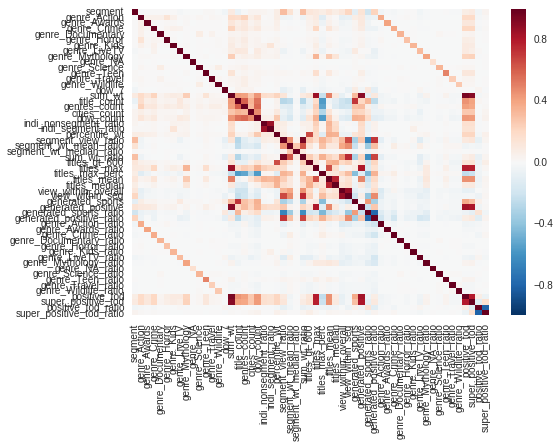

In [59]:
import matplotlib.pyplot as plt
plt.show()

In [72]:
np.mean(df_train[df_train.segment == 0].title_count)

12.115478091423313

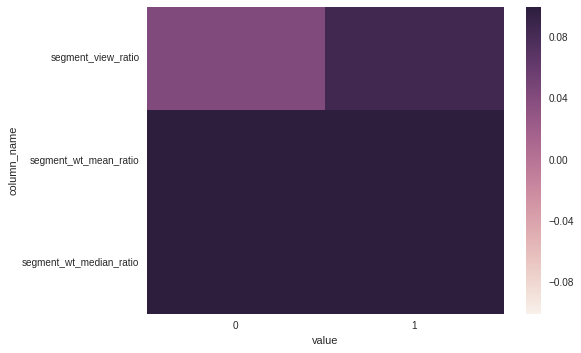

In [13]:
# cols = ["generated_sports", "generated_celeb", "generated_drama"]
cols = [i for i in df_train.columns if "segment" in i]
cols.remove("segment")

non_segment_means = []
segment_means = []
for i in cols:
    non_segment_means.append(np.mean(df_train[df_train.segment == 0][i]))    
    segment_means.append(np.mean(df_train[df_train.segment == 1][i]))

new_df = pd.DataFrame({"column_name":cols+cols, "value":[0]*len(cols) + [1]*len(cols), "y_mean":non_segment_means + segment_means})
new_df = new_df.pivot('column_name', 'value', 'y_mean')

# plt.figure(figsize=(8,80))
sns.heatmap(new_df)
plt.show()

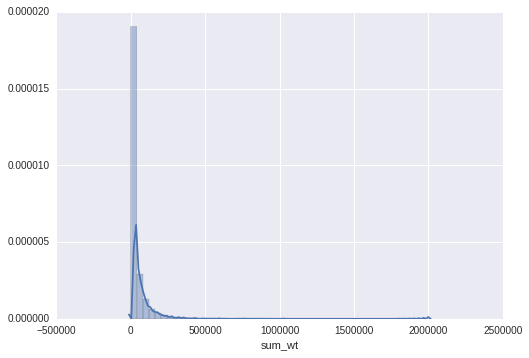

In [29]:
sns.distplot(df_train[df_train.segment == 1].sum_wt)
plt.show()

In [35]:
df_train[df_train.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
genre_Action,15255.0,1.873776e-02,0.105561,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_Awards,15255.0,4.352549e-03,0.047546,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_Crime,15255.0,1.983909e-02,0.114069,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_Documentary,15255.0,3.483273e-04,0.014432,0.000000,0.000000,0.000000,0.000000,9.808612e-01
genre_Horror,15255.0,4.110050e-03,0.051497,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_Kids,15255.0,4.130145e-03,0.048697,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_LiveTV,15255.0,5.867077e-03,0.057672,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_Mythology,15255.0,1.508357e-02,0.106242,0.000000,0.000000,0.000000,0.000000,1.000000e+00
genre_NA,15255.0,1.024254e-06,0.000127,0.000000,0.000000,0.000000,0.000000,1.562500e-02
